In [1]:
# import soundfile as sf
# !pip install numpy
# !pip install librosa
# !pip install pandas
# !pip install matplotlib
# !pip install --upgrade setuptools
# !pip install dtw --user
# !py -m pip install --upgrade pip setuptools wheel
# !conda install statsmodels
import statsmodels.api as sm
import numpy as np
import os
import librosa
import IPython.display as ipd
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import torch
import torchaudio
import torchaudio.transforms
import torch.nn as nn
import librosa
from openunmix import predict
from openunmix.utils import load_separator
import openunmix
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as DataLoader
# import torchvision.datasets as Datasets
# import torchvision.transforms as transforms

In [28]:
#First loading both the user and the singer wav files
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
# separator = torch.hub.load('sigsep/open-unmix-pytorch', 'umxhq')
# separator = openunmix.umxhq(['vocals'], residual=True, device=device)
# separating = load_separator('model', targets=['vocals'], device=device, residual=True)
# separator = openunmix.Separator(target_models=['vocals'], device=device, residual=True)
separator = load_separator('D:/Yash Mulik Study/Mini-Project/github_codespace/Song-Evaulation-System/model', targets=['vocals'], device=device, residual=True)

# audio_signal,sr = torchaudio.load('D:/Yash Mulik Study/Mini-Project/github_codespace/Song-Evaulation-System/wav/og1.wav')
# audio_signal = audio_signal
# audio_signal = openunmix.utils.preprocess(audio_signal, rate = sr)
# estimates = separator(audio_signal)

# estimates = separator(audio_signal[0])
# estimates = estimates.cpu().detach().numpy()
# print(estimates)


def audio_signal(path):
    audio, sr = torchaudio.load(path)
    return audio, sr

user_audio, sr1 = audio_signal('D:/Yash Mulik Study/Mini-Project/github_codespace/Song-Evaulation-System/wav/og1.wav')
user_audio = openunmix.utils.preprocess(user_audio, rate = sr1, model_rate=sr1)
user_audio = separator(user_audio)[0][0][0].reshape(-1,1).T

# # og_audio, sr2 = audio_signal('D:/Yash Mulik Study/Mini-Project/github_codespace/Song-Evaulation-System/wav/og1.wav')
og_audio, sr2 = audio_signal('D:/Yash Mulik Study/Mini-Project/github_codespace/Song-Evaulation-System/wav/og1.wav')
og_audio = openunmix.utils.preprocess(og_audio, rate = sr2, model_rate=sr2)
estimates = separator(og_audio)
og_audio = estimates[0][0][0].reshape(-1,1).T

In [29]:
# print(user_audio.shape)
# print(estimates.shape)
# vocal = estimates[0][0][0].reshape(-1, 1)
# print(vocal.T.shape)
# ipd.Audio(vocal.T, rate=sr1)

type(user_audio)

torch.Tensor

In [37]:
user_audio = user_audio.detach().cpu().numpy()[0]
og_audio = og_audio.detach().cpu().numpy()[0]
og_audio.shape
# og_audio

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

<Axes: >

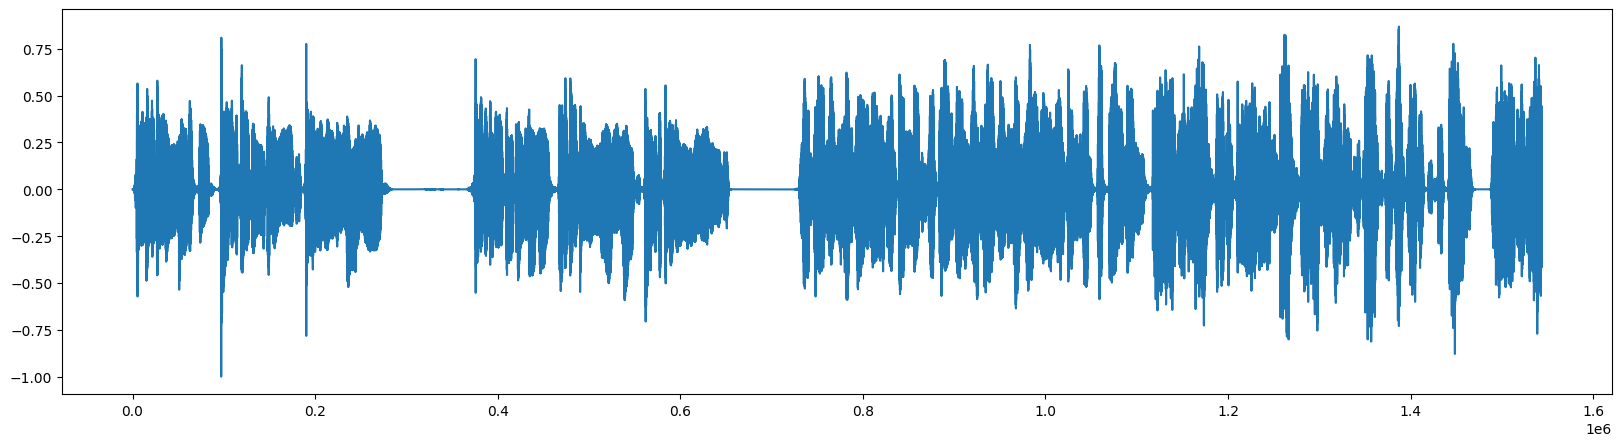

In [38]:
pd.Series(og_audio).plot(figsize=(20, 5))

In [39]:
# #Plotting thee audio signals
# figure, ax = plt.subplots(1,2, figsize=(20,5))
# figure.suptitle('Audio Signal Comparison')
# ax[0].plot(user_audio)
# ax[0].set_title('User Audio')
# ax[1].plot(og_audio)
# ax[1].set_title('Original Audio')
# plt.show()

Since we are only working with the vocals of both the user and the original singer audio, we don't have a beat to synchronize the original and the user audio. Thus, we will use the MFCCs to align the audio 

### Preprocessing codecell : 

In [40]:
#We first trim the silent part from the audio signal at the beginning and the end
def trim_audio(audio):
    return librosa.effects.trim(audio)[0]

#Resampling the audio signals
def resample_audio(audio, sr, target_sr):
    return librosa.resample(y=audio, orig_sr=sr, target_sr=44100)

def normalize_audio(audio):
    return librosa.util.normalize(audio)

#Extracting a subset of the audio signals for faster computation
def subset_audio(audio, sr):
    return audio[0: round(35*sr)]

#Dividing the song into frames 
def frames(audio):
    
    frame_length = round(0.032*44100)
    print(frame_length)
    frames = librosa.util.frame(audio, frame_length=frame_length, hop_length=512)
    return np.transpose(frames)

#Windowing a frame
def windowing(frame):
    #Using the hamm window
    return scipy.signal.get_window('hamming', frame.shape[0])

#L2 norm
def l2_norm(vector):
    return np.linalg.norm(vector, ord=2)

#L6 norm
def l6_norm(vector):
    return np.linalg.norm(vector, ord=6)

#DTW algorithm
def DTW(vec1, vec2):
    _, warp_path = librosa.sequence.dtw(X=vec1, Y=vec2, metric = 'euclidean' )
    return warp_path

#Equalizing the number of frames
def equalize_frames(frames1, frames2):
    if frames1.shape[0] > frames2.shape[0]:
        frames1 = frames1[:frames2.shape[0], :]
    else:
        frames2 = frames2[:frames1.shape[0], :]
    return frames1, frames2

#We also have to make sure that the Nan values in the audio signal is replaced by a mean of its neighbouring values
def replace_nan_values(audio):
    audio = pd.Series(audio)
    audio = audio.interpolate(method='linear')
    return np.array(audio.values)

us_backup = user_audio
og_backup = og_audio

user_audio = trim_audio(user_audio)
og_audio = trim_audio(og_audio)

print(f'After trimming : {user_audio.shape}')
print(f'Afte training og : {og_audio.shape}')


user_audio = resample_audio(user_audio, sr1, 22050)
sr1 = 44100
og_audio = resample_audio(og_audio, sr2, 22050)
sr2 = 44100

user_audio = normalize_audio(user_audio)
og_audio = normalize_audio(og_audio)

user_audio = subset_audio(user_audio, sr1)
print(user_audio.shape)
og_audio = subset_audio(og_audio, sr2)
print(og_audio.shape)

user_audio = replace_nan_values(user_audio)
og_audio = replace_nan_values(og_audio)

user_frames = frames(user_audio)
og_frames = frames(og_audio)


user_frames, og_frames = equalize_frames(user_frames, og_frames)
print(user_frames.shape)
print(og_frames.shape)


After trimming : (1543500,)
Afte training og : (1543500,)
(1543500,)
(1543500,)
1411
1411
(3012, 1411)
(3012, 1411)


### Pitch detection functions

In [41]:


def pitch_detection(y, sr):
    pitches, magnitudes = librosa.core.piptrack(y=y, sr=sr, n_fft=2048, hop_length=512)
    # get indexes of the maximum value in each time slice
    max_indexes = np.argmax(magnitudes, axis=0)
    # get the pitches of the max indexes per time slice
    pitches = pitches[max_indexes, range(magnitudes.shape[1])]
    return pitches

def med_sub_p(pitch_vector):
    median = np.median(pitch_vector)
    return pitch_vector - median

def pitch_features(frames, sr):
    l2n = []
    pmed=[]
    for frame in frames:
        pitch_vector = pitch_detection(frame, sr)
        # print(frame.shape, pitch_vector.shape)
        l2n.append(l2_norm(pitch_vector))
        medsubp = med_sub_p(pitch_vector)
        pmed.append(l2_norm(medsubp))
    l2n = pd.Series(l2n)
    pitch_der = l2n.diff()
    return np.array(pitch_der), np.array(pmed)

#Now we will create a function to find the mean absolute error  between the two vectors by passing their vectors and corresponding indices
def mae(vec1, vec2):
    vec1 = vec1[~np.isnan(vec1)]
    vec2 = vec2[~np.isnan(vec2)]
    return np.abs(vec1 - vec2).mean()

#We also want to find the root mean square error between the two vectors
def rmse(vec1, vec2):
    return np.sqrt(np.mean((vec1 - vec2)**2))


user_delta_p, user_pmed = pitch_features(user_frames, sr1)
og_delta_p, og_pmed = pitch_features(og_frames, sr2)

# def pitch_new(audio, sr):
#     pitches, magnitudes = librosa.core.piptrack(y=audio, sr=sr)
#     # get indexes of the maximum value in each time slice
#     max_indexes = np.argmax(magnitudes, axis=0)
#     # get the pitches of the max indexes per time slice
#     pitches = pitches[max_indexes, range(magnitudes.shape[1])]
#     l2norm = l2_norm(pitches)
#     return l2norm

# # #Plotting the pitch features
# figure, ax = plt.subplots(1,2, figsize=(20,10))
# figure.suptitle('Pitch Features')
# ax[0].plot(user_delta_p, color='red')
# ax[0].set_title('User Audio Delta Pitch vs Og Audio Delta Pitch')
# ax[0].plot(og_delta_p)
# ax[1].plot(user_pmed)
# ax[1].set_title('User Audio Median Pitch vs Og Audio Median Pitch')
# ax[1].plot(og_pmed)
# ax[1].set_title('Original Audio Median Pitch')
# plt.show()

#Also making a QQplot
# plt.figure(figsize=(10,10))
# sm.qqplot(user_delta_p, og_delta_p,line='45')
# plt.title('QQplot for User Audio Delta Pitch')
# plt.show()

C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1411
  warnings.warn(


In [42]:
# def pitch_new(audio, sr):
#     pitches, magnitudes = librosa.core.piptrack(y=audio, sr=sr)
#     # get indexes of the maximum value in each time slice
#     max_indexes = np.argmax(magnitudes, axis=0)
#     # get the pitches of the max indexes per time slice
#     pitches = pitches[max_indexes, range(magnitudes.shape[1])]
#     l2norm = l2_norm(pitches)
#     return l2norm


user_delta_p = user_delta_p.reshape(-1,1)
og_delta_p = og_delta_p.reshape(-1,1)

In [43]:
#Calculating the root mean square error based on the indices obtained by wp(no Nan values)

# wp = DTW(user_delta_p, og_delta_p)
# rmse_delta_p = rmse(user_delta_p, og_delta_p)
# print(f'RMSE Delta Pitch : {rmse_delta_p}')

### Pitch Implementation

In [44]:
meanabserr = mae(user_pmed, og_pmed)
mrse = rmse(user_pmed, og_pmed)
print(f'Mean Absolute Error of Delta Pitch : {meanabserr}')
    

Mean Absolute Error of Delta Pitch : 181.3134765625


### Rhythm detection functions and Speech

In [45]:
#For rhythm features, we will use the mfcc features for every frame

def mfcc_features(frames, sr):
    mfccs = []
    for frame in frames:
        # print(frame.reshape(-1,1).shape)
        mfcc = librosa.feature.mfcc(y=frame, sr=sr, n_mfcc=13, hop_length=220, n_fft=2048)
        mfccs.append(mfcc)
    return np.array(mfccs)

user_mfccs = mfcc_features(user_frames, sr1)
og_mfccs = mfcc_features(og_frames, sr2)

print(user_mfccs.shape)
print(og_mfccs.shape)


(3012, 13, 7)
(3012, 13, 7)


### Rhythm Implementation

In [46]:
#First we find the euclidean errors for each of the mfcc feature 
def mfcc_err(user_mfccs, og_mfccs):
    errors = []
    print(user_mfccs.T.shape)
    print(og_mfccs.T.shape)
    #Now we find the euclidean error for each frame
    for i in range(user_mfccs.shape[0]):
        error = np.linalg.norm(user_mfccs[i] - og_mfccs[i])
        errors.append(error)
    return np.array(errors)

mfcc_errors = mfcc_err(user_mfccs, og_mfccs)
# print(mfcc_errors.shape)
print(mfcc_errors.mean())


(7, 13, 3012)
(7, 13, 3012)
170.82541


### Range of Pitch

In [47]:
def rop(user_frames, sr):
    l2n = []
    for frame in user_frames:
        pitch_vector = pitch_detection(frame, sr)
        # print(frame.shape, pitch_vector.shape)
        l2n.append(l2_norm(pitch_vector))
    l2n = np.array(l2n)
    return l2n.max() - l2n.min()

rop_user = rop(user_frames, sr1)
rop_og = rop(og_frames, sr2)

print(rop_user)
print(rop_og)

6841.665
6858.5723


### Volume of the audio

In [48]:
#Function for short term log energy
def short_term_log_energy(frames):
    energy = []
    for frame in frames:
        energy.append(np.log(np.sum(frame**2)))
    return np.array(energy)

def energy_err(user_frames, og_frames):
    user_energy = short_term_log_energy(user_frames)
    print(user_energy.shape)
    og_energy = short_term_log_energy(og_frames)
    return (user_energy - og_energy).sum()

energy_errors = energy_err(user_frames, og_frames)
print(energy_errors)

(3012,)
-584.9275


SPR functions

In [51]:
def calculate_intensity(audio_data, sample_rate, window_func='hann'):

  audio_data = librosa.util.normalize(audio_data)  # Normalize audio
  stft = librosa.stft(audio_data, window=window_func)
  intensity_db = librosa.power_to_db(np.abs(stft) ** 2, ref=np.max(np.abs(stft)))
  return intensity_db

def find_peak_intensity(intensity_db, freq_range, sample_rate):
 
  nyquist = sample_rate / 2
  min_idx = int(freq_range[0] / nyquist * len(intensity_db))
  max_idx = int(freq_range[1] / nyquist * len(intensity_db))
  return np.max(intensity_db[min_idx:max_idx])

def singing_power_ratio(audio_data, sample_rate):

  intensity_db = calculate_intensity(audio_data, sample_rate)
  low_intensity_db = find_peak_intensity(intensity_db, (0, 2000), sample_rate)
  high_intensity_db = find_peak_intensity(intensity_db, (2000, 4000), sample_rate)
  
  
  if high_intensity_db == np.inf: 
    return float('inf')
  else:
    return 10 * np.log10(np.exp(low_intensity_db / 10) / np.exp(high_intensity_db / 10))  

ratio = singing_power_ratio(og_audio, sr1)
print(f"Singing power ratio: {ratio}")

Singing power ratio: 2.282000938319731
